# To Begin

This is a practical part of your ASR-TTS course. In total you will have 5 labs. Three of which will be focused on Automatic Speech Recognition and two on Text-to-Speech models. Each lab will last two hours and consist of two parts:
* Reading Part
* Coding Part 

In each part you might find question or tasks/activities to complete. The grading of the labs is explained below.

LAB 3/5

# What will you learn in LAB 2?

* What tensors are and how scalars, vectors, matrices, and higher-dimensional tensors are represented in practice.
* How tensor shapes encode meaning in ASR systems (e.g. batch size, time steps, feature dimensions).
* How to create, inspect, and manipulate tensors using common operations such as reshaping, transposing, and adding or removing dimensions.
* How typical ASR input and output tensors are structured, and why matching expected shapes is critical for models and losses.
* How common tensor shape mistakes arise in ASR pipelines (e.g. missing batch dimensions, swapped axes) and how to debug them.
* How underfitting and overfitting appear during ASR training, and how fine-tuning pre-trained models can help balance generalization and memorization.


# What Are Tensors?

A tensor is a container that holds numbers.
Nothing more. Nothing magical.
What makes tensors special is that they can have many dimensions and a shape that tells us how the numbers are organized.
In deep learning (and ASR), everything is a tensor: audio, features, model outputs, and labels.

In [1]:
import torch
import torch.nn as nn
import torchaudio
from speechbrain.inference.ASR import EncoderDecoderASR
from torch.utils.data import random_split


## Scalars — a tensor with no dimensions

A scalar is a single number.
It has no axes, only a value.

In [2]:
x = torch.tensor(3.14)
print(x)
print(x.shape)

# [] means: no dimensions.


tensor(3.1400)
torch.Size([])


## Vectors — one-dimensional tensors

A vector is a list of numbers.
It has one dimension.

In [3]:
v = torch.tensor([1.0, 2.0, 3.0])
print(v)
print(v.shape)


tensor([1., 2., 3.])
torch.Size([3])


## Question:

What is a dimension of a tensor? Explain in your own words.

In [5]:
# Answer
# A dimension of a tensor is one direction or axis along which data is organized.

Here is a full tensor example:

In [6]:
x = torch.tensor([
    [[1., 2., 3.],
     [4., 5., 6.],
     [7., 8., 9.]],

    [[10., 11., 12.],
     [13., 14., 15.],
     [16., 17., 18.]]
])

print(x)
print(x.shape)



tensor([[[ 1.,  2.,  3.],
         [ 4.,  5.,  6.],
         [ 7.,  8.,  9.]],

        [[10., 11., 12.],
         [13., 14., 15.],
         [16., 17., 18.]]])
torch.Size([2, 3, 3])


## Question: 

Explain what each number of torch.size output represente.

Answer:

the the number of elements across each dimension. i.e 2, 3x3 matrices

## Matrices — two-dimensional tensors

A matrix is a table of numbers with rows and columns.

In [7]:
m = torch.tensor([
    [1.0, 2.0, 3.0],
    [4.0, 5.0, 6.0]
])
print(m)
print(m.shape)


tensor([[1., 2., 3.],
        [4., 5., 6.]])
torch.Size([2, 3])


## Tensors — more than two dimensions

When we go beyond tables, we usually say tensor.
In ASR, tensors often have three dimensions or more.

Typical ASR tensor:

(batch, time, features)

Example:

In [8]:
x = torch.randn(8, 300, 80)
print(x.shape)


torch.Size([8, 300, 80])


Meaning:

* 8 audio files (batch)
* 300 time frames
* 80 features per frame

## The batch dimension (very important)

Neural networks are built to process many examples at the same time, not one by one. Doing things in parallel is much faster on GPUs and modern CPUs.

Instead of giving the model:
* “here is one audio file”

we give it:
* “here are many audio files at once”

The batch dimension tells the model:
“How many examples am I processing at the same time?”



## Question 

Create a tensor with 12 audio files, 500 time frames and 90 features per frame

In [9]:
# Code here

x = torch.randn(12, 500, 90)
print(x.shape)


torch.Size([12, 500, 90])


# Manipulating Tensors

## Reshaping — same numbers, different shape

Reshaping changes how numbers are grouped, not the numbers themselves.

In [10]:
x = torch.randn(8, 300, 80)
print(x.shape)
y = x.reshape(8, 24000)
print(y.shape)


torch.Size([8, 300, 80])
torch.Size([8, 24000])


## Transposing — swapping dimensions

Sometimes models expect dimensions in a different order.

In [11]:
x = torch.randn(8, 300, 80)
print(x.shape)
y = x.transpose(1, 2)
print(y.shape)


torch.Size([8, 300, 80])
torch.Size([8, 80, 300])


## Squeeze and Unsqueeze — adding or removing size-1 dimensions

Neural networks often expect tensors to have exact dimensions.

In [12]:
x = torch.randn(1, 300, 80)
print(x.shape)

y = x.squeeze(0)
print(y.shape)


torch.Size([1, 300, 80])
torch.Size([300, 80])


## Question:

squeeze removed a dimension, read the documentation and find a function to add a dimension: https://docs.pytorch.org/docs/stable/torch.html

add a dimension to the tensor below:

In [13]:
# Your code here
x = torch.randn(1, 300, 80)
print(x.shape)

y = x.unsqueeze(0)
print(y.shape)


torch.Size([1, 300, 80])
torch.Size([1, 1, 300, 80])


# Why tensor shapes cause most ASR bugs

In ASR, models expect very specific shapes.
If the shape is wrong, training crashes or gives nonsense results.

Common mistakes:

* Missing batch dimension
* Time and feature axes swapped
* Labels shape not matching predictions


Golden debugging rule:

print(tensor.shape)

👉 If you don’t know the shape, you don’t know what your code is doing.

## Question:

Below is a toy example of a model that has a bug. Debug it and fix the bug using one of the tensor manipulation techniques from this lesson.

Reread the lesson again if you neeed help fixing it.

HINT:

In ASR, most bugs happen at these boundaries:

* After feature extraction
* Before model forward
* Before loss / decoding

print the shapes!

* A lot of ASR bugs are literally “2D vs 3D”.

print("dims:", features.dim(), "shape:", features.shape)



In [17]:
class SimpleASR(nn.Module):
    def __init__(self, n_features=80, hidden=64, n_classes=30):
        super().__init__()
        self.rnn = nn.LSTM(n_features, hidden, batch_first=True)
        self.linear = nn.Linear(hidden, n_classes)

    def forward(self, x):
        if x.dim() != 3:
            raise ValueError(
                f"Expected input shape (B, T, F), got {x.shape}"
            )
        y, _ = self.rnn(x)
        return self.linear(y)

model = SimpleASR()

features = torch.randn(300, 80) 
features = features.unsqueeze(0)


out = model(features)             
print("Output shape:", out.shape)


Output shape: torch.Size([1, 300, 30])


## Question

Explain what was the bug in your own words, and what steps you took to debug it.

In [18]:
# Your answer
# The input tensor must have three dimensions: (B, T, F), but only 2 were provided. to fix it we need to add a batch dimension
#  using unsqueeze(0).

## Linear Layer

Think of a Linear layer as a very simple machine with two rules.

* The first rule is: how many numbers go in.
* The second rule is: how many numbers come out.

When you write nn.Linear(24000, 10), you are telling the machine: “I will give you 24000 numbers at a time, and you must give me back 10 numbers.” The machine does not care how many examples you give it at once — that part is handled automatically. It only checks the last group of numbers. So if you give it one example, it expects (24000) numbers; if you give it many examples, it expects (batch, 24000) numbers. After the Linear layer, each example now has 10 numbers instead of 24000, so the output shape becomes (batch, 10). 



In [30]:
class UtteranceClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(300 * 80, 10)

    def forward(self, x):
        return self.linear(x)

model = UtteranceClassifier()


features = torch.randn(4, 300, 80)
print("Input shape:", features.shape)
features = features.flatten(start_dim=1)
print("Input shape:", features.shape)

out = model(features)
print("Output shape:", out.shape)


Input shape: torch.Size([4, 300, 80])
Input shape: torch.Size([4, 24000])
Output shape: torch.Size([4, 10])


## Question:

Above is another toy code with a big, identify and fix it using tensor manipulation techniques from this lesson. Below, describe how you debugged it and solved it. 
Describe everything: what linear layer expected, what you gave it, what caused an error and so on.

HINT:
A Linear layer never understands tables — it only understands rows.

In [31]:
# # Your answer
# The linear layer nn.Linear(300×80, 10) expects a 2-D tensor of shape (batch_size, input_features), i.e. (B, 24000).
# However, the input tensor had shape (B, 300, 80), which is 3-D and represents a table (time × features) per example. 
# The bug was fixed by flattening the last two dimensions to obtain (B, 300·80), which matches the expected input of the linear layer.

## Question:

Below is another code with an error, for this code **use the audio file abailable in lab_3 folder**. Find the error and describe your debugging process. Keep in mind that these errors are induced bu me but they **often** occur when working with 3D data and asr.

In [33]:
asr = EncoderDecoderASR.from_hparams(
    source="speechbrain/asr-crdnn-rnnlm-librispeech",
    savedir="pretrained_models/asr-crdnn-rnnlm-librispeech",
)

audio_path = "/home/jbaalbaki/SpeechRecognition/ASR-TTS-Course/STEP2_Do_Your_Labs/Lab_3/audio.wav"  
wav, sr = torchaudio.load(audio_path)
wav = wav.mean(dim = 0, keepdim=True)
print("Loaded sample rate:", sr)
print("Loaded waveform shape (channels, time):", wav.shape)

if wav.shape[0] != 1:
    raise ValueError(
        f"Got {wav.shape} (channels={wav.shape[0]}). "
    )


wav_batch = wav 
wav_lens = torch.ones(wav.shape[0])

with torch.no_grad():
    text = asr.transcribe_batch(wav_batch, wav_lens)

print("\nTranscript:")
print(text)


/home/jbaalbaki/SpeechRecognition/ASR-TTS-Course/.venv/lib/python3.11/site-packages/speechbrain/processing/features.py:1529: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  st

Loaded sample rate: 16000
Loaded waveform shape (channels, time): torch.Size([1, 78480])

Transcript:
(['HE BEGAN A CONFUSED COMPLAINT AGAINST THE WIZARD WHO HAD VANISHED BEHIND THE CURTAIN ON THE LEFT'], [[16, 494, 5, 106, 42, 82, 4, 401, 172, 40, 7, 204, 65, 2, 226, 202, 200, 110, 35, 3, 325, 15, 186, 4, 666, 2, 619, 469, 39, 2, 402]])


# Fine-tunning

Fine-tuning means starting from a model that already knows general speech patterns (for example, wav2vec trained on thousands of hours of audio) and then slightly adjusting it on your own smaller dataset so it adapts to your task, instead of learning everything from scratch. In practice, this is done by freezing most of the pre-trained model and training only a small part (like the output layer), or by unfreezing layers gradually with a small learning rate so the model does not forget what it already knows; if you train too much or unfreeze too many layers with little data, the model will overfit and simply memorize the training examples.

# Fine-tuning a Wav2vec Model for Automatic Speech Recognition

The ASR system used in the first two labs relied on an acoustic model made up of two main components: a *feature* extractor (based on the [wav2vec](https://arxiv.org/pdf/2006.11477) architecture) and a *classifier* (a linear layer). The model then operates in two stages:

1. The speech waveform is passed to the feature extractor to transform it into a latent representation (= the *feature maps*).
2. The latent representation is passed to a classification layer to compute the probability of each character (= the *emission matrix*).

<center><img src="https://github.com/magronp/magronp.github.io/blob/master/images/wav2vec2asr.png?raw=true" width="800"></center>

To train such a model in practice, a two-stage proces is used. First, the wav2vec model alone is pre-trained in a self-supervised manner (using speech data only). Then, the classification layer is added and the whole model \{wav2vec+classifier\} is fine-tuned in a supervised manner (from speech+transcript data).

In the previous labs, we have used a whole model that was already pre-trained and fine-tuned for ASR. In this lab, we start from the pre-trained wav2vec model, and we reproduce the process of fine-tuning it for ASR. 

In [34]:
import torch
from torch import nn
from torch.utils.data import Dataset
import torchaudio
import IPython
import os
import fnmatch
import copy
import matplotlib.pyplot as plt

In [35]:
torch.random.manual_seed(0);

MAX_FILES = 100 # lower this number for processing a subset of the dataset

In [37]:
# Main dataset path - If needed, you can change it HERE but NOWHERE ELSE in the notebook!
data_dir = "/home/jbaalbaki/SpeechRecognition/ASR-TTS-Course/asr-dataset"

In [38]:
# Speech and transcripts sub-directories paths
data_speech_dir = os.path.join(data_dir, 'speech')
data_transc_dir = os.path.join(data_dir, 'transcription')

## Preparation

## Question

Audio file path: /home/jbaalbaki/SpeechRecognition/ASR-TTS-Course/asr-dataset/speech/61-70968-0001.wav


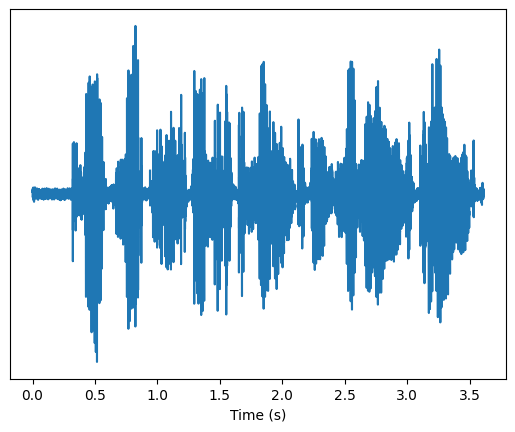

In [39]:
## Load an example audio file and plot a waveform the way we did in class 1
audio_file = '61-70968-0001.wav'
audio_file_path = os.path.join(data_speech_dir, audio_file)
print(f"Audio file path: {audio_file_path}")

waveform, sr = torchaudio.load(audio_file_path, channels_first=True)
IPython.display.Audio(data=waveform, rate=sr)

plt.figure()
xt = torch.arange(waveform.size(1)) / sr
plt.plot(xt, waveform.T)
plt.yticks([])
plt.xlabel("Time (s)")
plt.show()

In [61]:
# Write a function to get true transcript. Use the previous labs to help you
def get_true_transcript(transc_file_path):
    with open(transc_file_path, "r") as f:
        true_transcript = f.read()
    true_transcript = true_transcript.lower().replace('\n', ' ').replace(' ', '|').strip()
    return true_transcript
# Load and display the true transcription
transc_file_path = os.path.join(data_transc_dir, audio_file.replace('wav', 'txt'))
true_transcript = get_true_transcript(transc_file_path)
print(true_transcript)

give|not|so|earnest|a|mind|to|these|mummeries|child|


In [62]:
# We provide the list of labels (=characters) that can be found in the dataset
labels = ['-', '|', 'e', 't', 'a', 'o', 'n', 'i', 'h', 's', 'r', 'd', 'l', 'u', 'm',
          'w', 'c', 'f', 'g', 'y', 'p', 'b', 'v', 'k', "'", 'x', 'j', 'q', 'z']
n_labels = len(labels)

We need to transform the true transcript into a list of integers in order to feed it to a training loss function. To that end, we define a dictionary `dico_labels` that maps each character in the list of possible labels to an integer (for instance, `dico_labels['e']=2` or `dico_labels['a']=4`).

In [63]:
# using the 'labels' list above, define this dictionary
dico_labels = {}
for index, element in enumerate(labels):
    dico_labels[element] = index

In [64]:
# Apply dico_labels to the true transcript, and build a tensor from it
target_indices = [dico_labels[c] for c in true_transcript]
target_indices = torch.tensor(target_indices, dtype=torch.long)
print(target_indices)

tensor([18,  7, 22,  2,  1,  6,  5,  3,  1,  9,  5,  1,  2,  4, 10,  6,  2,  9,
         3,  1,  4,  1, 14,  7,  6, 11,  1,  3,  5,  1,  3,  8,  2,  9,  2,  1,
        14, 13, 14, 14,  2, 10,  7,  2,  9,  1, 16,  8,  7, 12, 11,  1])


## Acoustic model

Torchaudio comprises many models whose pretrained weights can be loaded directly (the list can be found [here](https://pytorch.org/audio/stable/pipelines.html#id3)). Here we use `WAV2VEC2_BASE`, which is pre-trained on speech data, but not fine-tuned for ASR.

We can apply it to the waveform to compute the feature maps, which is a tensor of size `[1, time steps, feature dim]` (recall that `1` corresponds to the batch size).

In [65]:
# Load the acoustic model: here it's a Wav2vec base that is not fine-tuned. Use previous labs to help you
model_name = 'WAV2VEC2_ASR_BASE_100H'
bundle = getattr(torchaudio.pipelines, model_name)
acoustic_model = bundle.get_model()

# Display model architecture
print(acoustic_model)

Wav2Vec2Model(
  (feature_extractor): FeatureExtractor(
    (conv_layers): ModuleList(
      (0): ConvLayerBlock(
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
      )
      (1-4): 4 x ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      )
      (5-6): 2 x ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
      )
    )
  )
  (encoder): Encoder(
    (feature_projection): FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (pos_conv_embed): ConvolutionalPositionalEmbedding(
        (conv): ParametrizedConv1d(
          768, 768, kernel_size=(128,), stride=(1,), padding=(64,), groups=16
          (parametriza

In [67]:
# Compute the feature maps
with torch.inference_mode():
    features, _ = acoustic_model(waveform)

print(features.shape)

torch.Size([1, 180, 29])


This model includes a wav2vec feature extractor (so it should be re-instaciated in the `__init__` method) and a linear classification layer that takes the feature maps and outputs log-probabilities per class (thus it has to use a [log softmax](https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html) activation after classification).

In [68]:
class Wav2vecASR(nn.Module):
    def __init__(self, output_size):
        super().__init__()

        self.wav2vec = getattr(torchaudio.pipelines, 'WAV2VEC2_BASE').get_model()
        self.feature_dim = self.wav2vec.encoder.feature_projection.projection.out_features
        self.output_layer = nn.Linear(self.feature_dim, output_size)
    
    def forward(self, x):
        features, _ = self.wav2vec(x)
        emission = self.output_layer(features)
        emission = emission.log_softmax(dim=-1)
        return emission


In [69]:
# Instanciate the model
output_size = n_labels
model = Wav2vecASR(output_size)

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960.pth" to /home/jbaalbaki/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960.pth
100%|██████████| 360M/360M [00:18<00:00, 20.3MB/s] 


In [70]:
# A function to count the number of trainable parameters
def count_tlearnable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Number of trainable parameters:', count_tlearnable_params(model))

Number of trainable parameters: 94393245


The model is very large (90M+ parameters) mostly because of the wav2vec part. To speed training in this lab, we freeze the wav2vec part and we only train the classification layer. To that end, we need to set `requires_grad = False` for the wav2vec's parameters.

In [ ]:
# Define a function to freeze parameters, apply it to "wav2vec" part of the model,
# and print the new number of trainable parameters
def freeze_params(m):
    for param in m.parameters():
        param.requires_grad = False
    return
    
model.wav2vec.apply(freeze_params)

print('Number of trainable parameters:', count_tlearnable_params(model))

In [ ]:
# Initialization function for the network's parameters
def init_params(m, seed=0):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data, generator=torch.manual_seed(seed))
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    return model 

In [ ]:
model.output_layer.apply(init_params)

In [ ]:
with torch.inference_mode():
    emission = model(waveform)
print(emission.shape)

# Vizualize the emission matrix
plt.figure()
plt.imshow(emission[0].cpu().T)
plt.title("Emission matrix")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.tight_layout()
plt.show()

In [ ]:
# We provide a function to get a transcript from the emission matrix (similar to the greedy decoder from lab 1)
def transcript_from_emission(emission, labels):
    indices = torch.argmax(emission, dim=-1)  # take the most likely index at each time step
    indices = torch.unique_consecutive(indices, dim=-1) # remove duplicates
    indices = [i for i in indices if i != 0] # remove the blank token
    transcript = "".join([labels[i] for i in indices]) # convert integers back into characters
    transcript = transcript.lower()
    return transcript

# The transcript using a non-trained model should look bad
print(transcript_from_emission(emission[0], labels))

## Dataset

We now need to define the `Dataset` class, to efficiently load the speech data and true transcript (in the form of indices / integers).

The `__getitem__` method returns three outputs:

- `waveform`: a tensor containing the speech waveform
- `true_transcript`: the true transcript as per using the provided loading function
- `target_indices`: a tensor containing the integers corresponding to the transcript

The `__init__` method should make use of the `MAX_FILES` variable to limit the size of the dataset (for speed).

In [ ]:
# ASR Dataset class
class ASRdataset(Dataset):
    def __init__(self, data_speech_dir, data_transc_dir, dico_labels, MAX_FILES=None):
        self.data_speech_dir = data_speech_dir
        self.data_transc_dir = data_transc_dir
        self.audio_files = self._find_files(data_speech_dir)[:MAX_FILES]
        self.dico_labels = dico_labels

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, index):
        # load the waveform
        audio_file = self.audio_files[index]
        audio_file_path = os.path.join(self.data_speech_dir, audio_file)
        waveform, _ = torchaudio.load(audio_file_path, channels_first=True)
        # load the true transcript
        transc_file_path = os.path.join(self.data_transc_dir, audio_file.replace('wav', 'txt'))
        true_transcript = get_true_transcript(transc_file_path)
        # transform transcript into list of integers
        target_indices = [self.dico_labels[c] for c in true_transcript]
        target_indices = torch.tensor(target_indices, dtype=torch.long)
        return waveform, true_transcript, target_indices

    def _find_files(self, directory, pattern='*.wav'):
        """Recursively finds all files matching the pattern."""
        files = []
        for root, _, filenames in os.walk(directory):
            for filename in fnmatch.filter(filenames, pattern):
                files.append(filename)
        files = sorted(files)
        return files


In [ ]:
# Instanciate the ASR dataset and print its length
asrdataset = ASRdataset(data_speech_dir, data_transc_dir, dico_labels, MAX_FILES=MAX_FILES)
print('Dataset length:', len(asrdataset))

# Get the first data sample, and print some information
waveform, true_transcript, target_indices = asrdataset[0]
print(waveform.shape)
print(true_transcript)
print(target_indices)

In real-life applications (and as we usually do in the "Neural Networks" labs), we assemble the data samples into *batches* for efficiency. However, our data points here have different lenghts in general: two speech waveforms / two transcripts are not guaranteed to have the same duration / number of characters. Therefore, in such a case we need to customize the dataloader such that it performs some [padding operation](https://www.codefull.org/2018/11/use-pytorchs-dataloader-with-variable-length-sequences-for-lstm-gru/) in order to yield data samples of same length. However, to keep things simple in this lab, we skip this padding operation, and we do not work with batches but rather iterate over the dataset directly.

## Training with the CTC loss

For a given data sample in the dataset, we have:
- the emission matrix (log-probability of each character over time frames)
- the true transcript (represented as a list of integers corresponding to each character)

However, to train our network, we need to obtain an estimated transcript so that we can compute a loss between the true and estimated transcripts. This requires some post-processing of the emission matrix, but the good news is that we don't have to do it, the [CTC loss](https://pytorch.org/docs/stable/generated/torch.nn.CTCLoss.html) handles that for us!

In lab 2 we have use the CTC algorithm to perform inference, but it can also be used as a loss function to train an ASR network. Not only the CTC loss handles the post-processing from the emission matrix, but its great advantage is that it performs alignment from input/output pairs of different lengths, so we don't have to explicitly align each character in the transcript with a time frame in the emission matrix.

In Pytorch, [CTC loss](https://pytorch.org/docs/stable/generated/torch.nn.CTCLoss.html) is fed with the the emission matrix and the tensor containing target indices (corresponding to the true transcript). We also need to give it the input and target lengths explicitly: indeed, even though here we don't manipulate batches / we don't do padding, in general this would be the case so we need to let the function know what is the actual input/target length (before padding).

In [ ]:
# Compute the emission matrix (not in inference mode such that we keep track of the gradients)
emission = model(waveform)
emission = emission[0] #remove the "batch" dimension (since here batch_size=1)

# Define the input and target lengths as tensors
T = emission.shape[0]
L = len(target_indices)
input_length = torch.tensor(T, dtype=torch.long)
target_length = torch.tensor(L, dtype=torch.long)

# Instanciate a loss object
ctc_loss = nn.CTCLoss()

# Compute the loss
loss = ctc_loss(emission, target_indices, input_length, target_length)
print(loss.item())

# Compute the gradients
loss.backward()

Function `training_wav2vecASR` is used to train the model. It is similar to what you usually do in the Neural Networks labs, although here you do not build batches of data (thus we don't need a `Dataloader` object). Instead, you directly iterate over the `Dataset`. The training function uses an Adam optimizer, and no validation.

In [ ]:
#Training function
def training_wav2vecASR(model, train_dataloader, num_epochs, loss_fn, learning_rate):

    model_tr = copy.deepcopy(model)
    model_tr.train()
    optimizer = torch.optim.Adam(model_tr.parameters(), lr=learning_rate)
    train_losses = []

    for epoch in range(num_epochs):
        tr_loss = 0
        for data_sample in asrdataset:
            
            # Get the data
            waveform, true_trans, target_indices = data_sample
            
            # Apply the model
            emission = model_tr(waveform)
            emission = emission.squeeze()
            
            #print(true_trans)
            #print(transcript_from_emission(emission, labels))

            # Get the input and target lengths
            input_length = torch.tensor(emission.shape[0], dtype=torch.long)
            target_length = torch.tensor(len(target_indices), dtype=torch.long)
    
            # Compute the CTC loss
            loss = loss_fn(emission, target_indices, input_length, target_length)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            tr_loss += loss.item()
    
        # Normalize and store loss
        tr_loss = tr_loss / len(asrdataset)
        train_losses.append(tr_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {tr_loss:.4f}")

    return model_tr, train_losses

In [ ]:
# Training parameters (only one epoch for speed)
num_epochs = 1
learning_rate = 0.1
loss_fn = nn.CTCLoss()

model_tr, train_losses = training_wav2vecASR(model, asrdataset, num_epochs, loss_fn, learning_rate)

## Question: 

What do you observe about the training process? Is it fast or slow? Why?

## Overfitting on one sample

Even when the training is slow, we can assess that our training pipeline works properly by conducting training on a unique sample, and checking the transcript on the same sample. This technique (= overfitting on one sample) is useful to "crash test" if everything runs and if our model / training pipeline has any chance to work on a larger dataset.

We will instanciate a model from scratch, freeze the wav2part, and initialize the classification layer. Build a dataset made up of 1 sample (use the `MAX_FILES` parameter), and conduct training for 50 epoch using this dataset. Once the model is trained, you will compute the emission matrix from this sample's waveform and the estimated transcript. Display the true and estimated transcripts. Also do the same on another sentence so that you can assess that the model is not able to generalize properly.

In [ ]:
# Instanciate a model, freeze the wav2vec part, and initialize the classifier
model = Wav2vecASR(n_labels)
model.wav2vec.apply(freeze_params)
model.output_layer.apply(init_params)

# Build a very small dataset
asrdataset = ASRdataset(data_speech_dir, data_transc_dir, dico_labels, MAX_FILES=1)

# Training
num_epochs = 50
model_tr, train_losses = training_wav2vecASR(model, asrdataset, num_epochs, loss_fn, learning_rate)

# Save the model's parameters
torch.save(model_tr.state_dict(), 'model_wav2vecASR.pt')

In [ ]:
# Load the data sample
waveform, true_transcript, _ = asrdataset[0]

# Instanciate the model and load the trained parameters
model = Wav2vecASR(n_labels)
model.load_state_dict(torch.load('model_wav2vecASR.pt', weights_only=True))

# Apply the model and get the estimated transcript
with torch.inference_mode():
    emission = model(waveform)
    est_transcript = transcript_from_emission(emission[0], labels)



In [ ]:
## Display true and estimated transcripts here

In [ ]:
# Try it on a different sentence

In [ ]:
## Display true and estimated transcripts here 

## Question

When training the model how do you know if the model is learning properly, what do you code and inspect? Explain in depth.
Documentation to read: https://medium.com/data-science/learning-curve-to-identify-overfitting-underfitting-problems-133177f38df5

In [ ]:
## Your answer

# Evaluating Models

We need a new function to be able to split the dataset into train and val. To choose a good validation split, the validation data must be completely unseen during training and representative of the same task and conditions as the training data; a common rule of thumb is to keep about 10–30% of the data for validation, making sure it contains different speakers or utterances when possible, and to use it to monitor when validation performance stops improving, which tells you when to stop fine-tuning or adjust your hyperparameters.

In [ ]:
def training_wav2vecASR2(model, train_dataset, val_dataset, num_epochs, loss_fn, learning_rate):
    model_tr = copy.deepcopy(model)
    model_tr.train()

    optimizer = torch.optim.Adam(model_tr.parameters(), lr=learning_rate)
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        tr_loss = 0.0

        for waveform, true_trans, target_indices in train_dataset:
            emission = model_tr(waveform)
            emission = emission.squeeze()

            input_length = torch.tensor(emission.shape[0], dtype=torch.long)
            target_length = torch.tensor(len(target_indices), dtype=torch.long)

            loss = loss_fn(emission, target_indices, input_length, target_length)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            tr_loss += loss.item()

        tr_loss = tr_loss / max(1, len(train_dataset))
        train_losses.append(tr_loss)

        # validation curve
        vl_loss = eval_ctc_loss(model_tr, val_dataset, loss_fn)
        val_losses.append(vl_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}]  Train: {tr_loss:.4f}  Val: {vl_loss:.4f}")

    return model_tr, train_losses, val_losses


In [ ]:
def eval_ctc_loss(model, dataset, loss_fn):
    model.eval()
    total = 0.0

    with torch.no_grad():
        for waveform, true_trans, target_indices in dataset:
            emission = model(waveform)  

            emission = emission.squeeze()

            input_length = torch.tensor(emission.shape[0], dtype=torch.long)
            target_length = torch.tensor(len(target_indices), dtype=torch.long)

            loss = loss_fn(emission, target_indices, input_length, target_length)
            total += loss.item()

    model.train()
    return total / max(1, len(dataset))


In [ ]:
MAX_FILES = 50  
asrdataset = ASRdataset(data_speech_dir, data_transc_dir, dico_labels, MAX_FILES=MAX_FILES)

val_ratio = 0.2
n_total = len(asrdataset)
n_val = max(1, int(n_total * val_ratio))
n_train = n_total - n_val

train_ds, val_ds = random_split(asrdataset, [n_train, n_val])

print("Train:", len(train_ds), "Val:", len(val_ds))


In [ ]:
model_tr, train_losses, val_losses = training_wav2vecASR(
    model, train_ds, val_ds, num_epochs=50, loss_fn=loss_fn, learning_rate=learning_rate
)

plt.figure()
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("CTC loss")
plt.title("Overfitting demo: train vs validation")
plt.legend()
plt.show()


## Question

Experiment with MAX_FILES and tell me any changes you observe in the graph. Why do they occur?

In [ ]:
# Your code

## Question

Experiment with validation split and tell me any changes you observe in the graph. Why do they occur?

In [ ]:
# Your code

# Optimizers

In deep learning, **optimizers** are the algorithms that decide how a model’s parameters are updated during training, and different optimizers behave differently (for example, SGD, Adam, RMSprop). In this course we use **Adam**, which is a popular choice for fine-tuning because it adapts the learning step automatically for each parameter, but it also exposes several **tunable hyperparameters** that strongly affect training behavior. During fine-tuning, these parameters can change how fast the model learns, how stable training is, and how much the model overfits. **Read the official Adam documentation** and identify which parameters can be adjusted (such as those controlling step size, regularization, and gradient smoothing), and to think about how changing them would affect training and validation curves during fine-tuning.

https://www.analyticsvidhya.com/blog/2023/12/adam-optimizer/

## Question

Lits Adam's parameters that can be fine-tuned and what they are responsible for.

## Question

Experiment with one of Adam's parameters, describe the outcome and any changes you observe in the graphs. 

## Additional Material on TDNN and CNN

TDNN: https://kaleidoescape.github.io/tdnn/

CNN: https://towardsdatascience.com/convolutional-neural-networks-explained-9cc5188c4939/

IN SHORT: 

A CNN (Convolutional Neural Network) is a model that learns by looking at small pieces of data at a time and reusing the same pattern-detector everywhere, like sliding a small window along the data to spot useful patterns. A TDNN (Time-Delay Neural Network) does the same thing, but specifically for data that changes over time, such as speech: it looks at a few time steps before and after the current moment to understand what is happening now. In practice, a TDNN is simply a 1-dimensional CNN applied along the time axis, designed to recognize temporal patterns while being insensitive to small time shifts.

A one-dimensional CNN (1D CNN) is a neural network that looks for patterns along a single line, not across a 2-D surface like an image. Imagine a row of numbers changing over time, such as a speech signal, sound features, or a sentence represented as numbers. A 1D CNN uses a small moving window that slides left to right along this row and checks each small chunk for patterns (for example, a short sound shape or a word pattern). The same detector is reused everywhere, so the network learns to recognize a pattern no matter where it appears in time. This makes 1D CNNs good at handling sequences like audio, where timing may shift slightly but the pattern itself stays the same.

## Question:

Read the materials on CNN AND TDNN and explain the architecture in your own words, be detailed. What are the advantages of TDNN compared to CNN?

## Coding blocks and questions that will be tested next class:

In [ ]:
# INSPECTING TENSOR SHAPE
x = torch.randn(300, 80)
print("dims:", x.dim())
print("shape:", x.shape)


In [ ]:
# ADDING DIMENSION
x = torch.randn(300, 80)
x = x.unsqueeze(0)
print(x.shape)  # (1, 300, 80)



* What is a tensor, in simple words?
* Give me an example tensor used as input into the linear layer of an asr system and explain the contents.
* Give me three different ways to manipulate tensors and explain what they do.
* What is overfitting, and how does it appear on training vs validation loss curves?
* What is underfitting, and how do its loss curves look?
* Explain how Adam optimizer works in short, What is the role of it in neural network training?
* What parameters does Adam optimizer have, what are they responsible for?
* What is the benefit of the TDNN architecture compared to a conventional CNN? Explain both architectures. (You will need to google for this one or refer to your lecture slides)
